## Importing Libraries

__Issues Faced:__<br>
Faced major issues in this part. Had a very tough time importing torch and torchvision.<br>
They kept clashing with other versions of other libraries that were installed.<br>
Finally, I had to keep solving it issue by issue by mannually updating each version.<br>
Time taken to resolve: about 20hrs

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import pickle
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import PIL

## Loading GPU for training

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

## Transfor for resizing images and converting them to tensors

In [3]:
transform = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor()
])

## Creating Image Dataset using pytorch ImageFolder Class
__Source:__ https://www.robots.ox.ac.uk/~vgg/data/pets/

In [4]:
dataset = ImageFolder("E:\Quarter 2\Applied Data Analytics\Project\data", transform=transform)

## Creating Train Test split

In [5]:
train_set, val_set = torch.utils.data.random_split(dataset, [6651,739])

## Creating the Train and Test dataLodaers to feed tensors to GPU

In [6]:
# Taking train as batches of 64
train_dataloader = DataLoader(train_set, shuffle = True, batch_size = 64, pin_memory = True, num_workers = 0)
# Taking the test as a whole
test_dataloader = DataLoader(val_set, shuffle = True, batch_size = len(val_set), pin_memory = True, num_workers = 0)

## Testing dataloading loop for train and validation set

In [7]:
# This Prints the size and tesors for train_dataloader batch by batch.

# for (train_img_batch,train_label_batch) in train_dataloader:
#     print(train_img_batch.size())
#     print(train_label_batch)

In [8]:
# This prints the size and tesors for test_dataloader all at a time.
# This it the same format it would print for the above part.

for (valid_img_batch,valid_label_batch) in test_dataloader:
    print(valid_img_batch.size())
    print(valid_label_batch)

torch.Size([739, 3, 200, 200])
tensor([14, 21, 25,  9, 32, 36, 24, 26, 14, 15,  4, 28, 16,  4, 14, 21, 26,  0,
         8, 29, 32, 32, 16,  6, 28, 13, 14, 15, 36, 11, 18,  7, 23, 30,  9, 15,
        17, 16, 15, 24, 27, 18, 19,  2, 31,  9, 24, 14, 11,  0, 21, 32, 25,  8,
        27, 14, 20, 27,  0,  3, 15,  8, 26, 36, 32,  0,  5, 29,  9, 27,  5,  8,
        31, 23, 16, 14,  4,  5, 30, 14, 21, 25,  5,  9, 19, 29, 36,  4, 18, 15,
        28, 24, 35, 23,  9,  2, 34, 24, 10, 21, 26, 28, 33, 29,  9,  0,  2, 34,
        22, 24, 29, 25, 33, 35, 31, 15, 24,  0, 23, 24,  6, 14,  0, 29,  4, 29,
        17, 32, 20, 29, 21, 10, 15, 11,  9,  6,  2, 20,  6, 22, 23, 10, 12,  3,
         8, 27,  6, 25, 12,  0, 31, 21, 32, 21,  3, 15, 12, 36, 28, 20,  9, 15,
         3, 13,  3, 12,  1, 33, 20, 28, 18, 31, 11,  6, 14,  2, 13, 32, 25, 27,
         6,  2,  6, 36,  0, 32, 24, 31, 30, 32,  8,  0, 20, 27, 26, 23, 24, 31,
         1,  6, 22, 30, 20, 12, 20, 21, 16, 20, 15, 35,  0,  6, 16,  1, 34, 22,
         

## CNN Model - ResNet18

Used the pretrained model as it was trained on 1000 classes. I am using 37. It didn't make sence for me to train it.<br>
__Source:__ https://towardsdatascience.com/transfer-learning-using-pytorch-4c3475f4495

In [9]:
# Loading pretrained ResNet18 model
model_resnet = resnet18(pretrained = True).to(device)
# Setting gradient requirement for weights to false to avoid backpropagation through those layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Modifying last layer to change the num of output_features to num of classes in the cats and dogs species dataset 
# Grabbing number of neurons in the second last layer
hidden_units_second_last = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(hidden_units_second_last, 37).to(device)

## Creating test and train functions

In [10]:
# Function to get testing accuracy
def test_accuracy_check(loader, model):
    # Images that are classified correctly
    num_correct = 0  
    # Number of samples checked
    num_samples = 0  
    # Set resnet to evaluation mode
    model.eval()  
    
    # Gradient calculation isn't needed while testing
    with torch.no_grad():  
        for imgs, labels in loader:
            # Move labels to GPU
            labels = labels.to(device)
            # Move images to GPU
            imgs = imgs.to(device)    
            # Probability for each of the 37 classes
            scores = model(imgs)  
            # Class with highest probability
            predictions = torch.tensor([torch.argmax(i).item() for i in scores]).to(device)  
            # Correctly classified images
            num_correct = num_correct + (predictions == labels).sum()  
            # Increasing total samples by batch size
            num_samples = num_samples + predictions.size(0) 
            
    # Calculating accuracy
    acc = float(num_correct)/float(num_samples)*100  
    print(f"Got {num_correct} / {num_samples} with test accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    
    # Reset model to train for next epochs
    model.train()  
    return acc

In [11]:
# Function to trains batchwise
def train(batch_size):
    # setting model to train mode
    model_resnet.train()  
    epoch_lost_list = []
    train_accuracies = []
    test_accuracies = []
    
    # Itereate through the entire dataset for each epoch
    for epoch in range(num_epochs):  
        epoch_loss = 0
        num_correct = 0 
        num_samples = 0 
        print("epoch:", epoch + 1)
        
        # trainloader returns a tuple -> (batch of images, corresponding vector of labels)
        for imgs, labels in train_dataloader:  
            # Feedforward Section
            imgs = imgs.to(device) 
            labels = labels.to(device) 
            outputs = model_resnet(imgs)  # output of feedforward neural network before softmax layer
            
            # Backpropagation Section
            loss = criterion(outputs, labels)  # calculate the softmax output and loss per batch of the images
            optimizer.zero_grad()  # set the optimizer matrix to zero before calculating the gradients for every batch
            loss.backward()  # calculate the gradients through differentiation (dL/dW)
            epoch_loss= epoch_loss + loss.item()
            optimizer.step()  # updation of weights (w = w - dL/dW)
            
            # Prediction Section
            predictions = torch.tensor([torch.argmax(i).item() for i in outputs]).to(device)  # using trained weights to predict the output.
            num_correct = num_correct + (predictions == labels).sum()  # if predictions vector matches labels vector, we increment num_correct by the number of correct predictions
            num_samples = num_samples + predictions.size(0)  # increment the number of samples by batchsize
        epoch_lost_list.append(epoch_loss / (len(train_set) // batch_size))
        train_accuracies.append(float(num_correct) / float(num_samples) * 100)
        print(f"Got {num_correct} / {num_samples} with train accuracy {float(num_correct) / float(num_samples) * 100:.2f}\n") # print training accuracy per epoch
        print("Train Loss Epoch: ",epoch_loss / (len(train_set) // batch_size))
        
        # Calculate test accuracy every epoch
        test_acc = test_accuracy_check(test_dataloader, model_resnet)
        test_accuracies.append(test_acc)
        
        # Save at every 10 epochs
        if (epoch+1)%10:
            torch.save(model_resnet,f"trained_classification_model_{epoch + 1}.pt")

## Setting hypyerparameters

In [12]:
num_epochs = 100
learning_rate = 0.001

In [13]:
# Function callout for softmax output and loss calculation
criterion = nn.CrossEntropyLoss() 
# Optimizer set to Adam
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=learning_rate) 

## Training

In [14]:
if __name__ == '__main__':
    train(64)

epoch: 1
Got 4018 / 6651 with train accuracy 60.41

Train Loss Epoch:  1.845552155693758
Got 603 / 739 with test accuracy 81.60
epoch: 2
Got 5658 / 6651 with train accuracy 85.07

Train Loss Epoch:  0.7282402642722269
Got 618 / 739 with test accuracy 83.63
epoch: 3
Got 5834 / 6651 with train accuracy 87.72

Train Loss Epoch:  0.5323245102919422
Got 629 / 739 with test accuracy 85.12
epoch: 4
Got 5951 / 6651 with train accuracy 89.48

Train Loss Epoch:  0.43801006848372304
Got 636 / 739 with test accuracy 86.06
epoch: 5
Got 6041 / 6651 with train accuracy 90.83

Train Loss Epoch:  0.38085861518545056
Got 641 / 739 with test accuracy 86.74
epoch: 6
Got 6104 / 6651 with train accuracy 91.78

Train Loss Epoch:  0.3432744214835676
Got 638 / 739 with test accuracy 86.33
epoch: 7
Got 6128 / 6651 with train accuracy 92.14

Train Loss Epoch:  0.3110280301675056
Got 651 / 739 with test accuracy 88.09
epoch: 8
Got 6147 / 6651 with train accuracy 92.42

Train Loss Epoch:  0.2940712128449412
Got 64

KeyboardInterrupt: 

## Evaluation Metrics Visualization

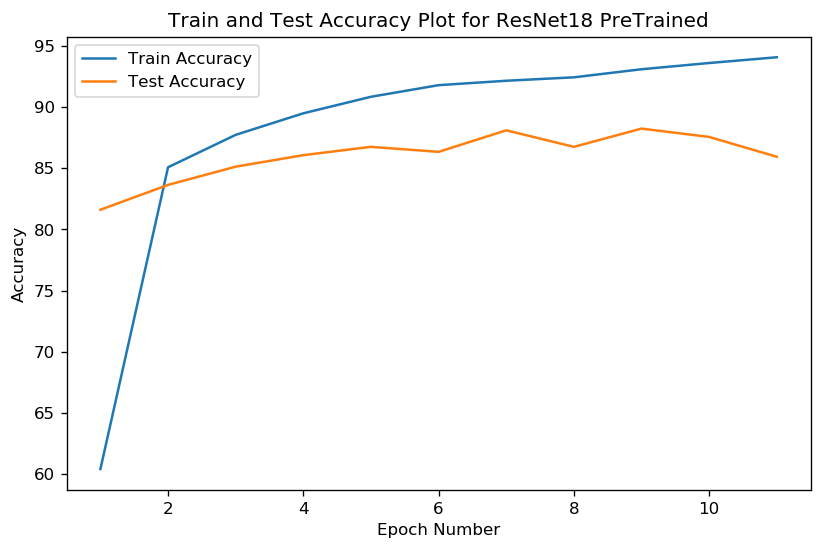

In [14]:
# Train/Test Accuracy Plot
plt.figure(figsize = (8,5),dpi=120)
metrics_df = pd.DataFrame(columns = ["Epoch","Train Accuracy","Test Accuracy","Training Loss"], dtype="float")
metrics_df["Epoch"] = [i+1 for i in range(11)]
metrics_df["Train Accuracy"] = [60.41,85.07,87.72,89.48,90.83,91.78,92.14,92.42,93.08,93.59,94.06]
metrics_df["Test Accuracy"] = [81.60, 83.63, 85.12, 86.06, 86.74, 86.33, 88.09, 86.74, 88.23, 87.55, 85.93]
metrics_df["Training Loss"] = [1.845552155693758, 0.7282402642722269, 0.5323245102919422, 0.43801006848372304, 0.38085861518545056, 0.3432744214835676,  0.3110280301675056, 0.2940712128449412, 0.26816144513273704, 0.25178689921943886, 0.23677386112004808]
plt.plot(metrics_df["Epoch"], metrics_df["Train Accuracy"],label = "Train Accuracy")
plt.plot(metrics_df["Epoch"], metrics_df["Test Accuracy"],label = "Test Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy Plot for ResNet18 PreTrained")
plt.legend()
plt.savefig('Train vs Test Accuracy Plot.png')
plt.savefig('Train vs Test Accuracy Plot.pdf')
plt.show()
plt.close()

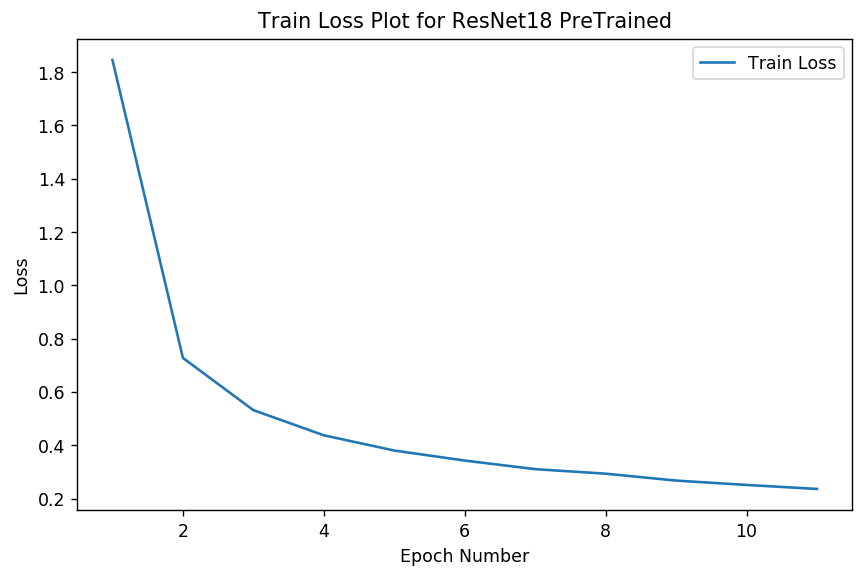

In [15]:
# Train Loss Plot
plt.figure(figsize = (8,5), dpi = 125)
plt.plot(metrics_df["Epoch"], metrics_df["Training Loss"],label = "Train Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Train Loss Plot for ResNet18 PreTrained")
plt.legend()
plt.savefig('Train Loss Plot.png')
plt.savefig('Train Loss Plot.pdf')
plt.show()
plt.close()

## Creating Image Grid for Visual Analysis

In [16]:
# Loading the best test accuracy corresponding model:
model_inference = torch.load("trained_classification_model_9.pt", map_location=torch.device('cpu')).to(device)

In [17]:
for img_test_batch,test_labels in test_dataloader:
    img_test_batch = img_test_batch.to(device)
    print(img_test_batch.size())
    print(test_labels)

torch.Size([739, 3, 200, 200])
tensor([27, 33, 20, 31, 28,  6, 21, 16,  0, 10, 29,  3, 18, 33, 10, 33, 29, 36,
        15, 27, 15, 13, 24, 18,  5, 10,  8, 12, 24, 13,  0, 18,  1, 13, 27, 35,
        16, 15,  5,  0, 31, 12, 21, 22,  4, 35, 34,  4,  3,  4, 32, 36, 17,  1,
         4, 26, 35, 33, 13,  9, 30, 27,  9, 23, 18, 16, 18, 28, 25,  4,  9,  9,
         3,  0, 15, 30,  4, 23, 25, 24, 12,  9, 29,  6, 19,  7, 25,  8,  0,  7,
        12, 24,  5,  4, 23, 24,  4,  6, 17, 25,  1,  4, 25, 15,  0, 36,  8, 20,
        27, 10, 28, 20,  1, 16, 14, 24, 23, 26, 31, 33, 32,  6, 11, 15,  6,  5,
        20,  5, 18, 19, 18, 36,  9,  3, 31,  1, 36, 30, 30, 14, 12, 32,  1, 19,
        25, 16, 23, 27,  8, 20, 11, 15, 11,  3, 19, 21, 20, 15, 16, 34, 29, 17,
        35, 17,  3, 26, 24, 22, 36,  4, 33, 32, 20, 20,  1, 14, 24, 18,  8, 32,
        15, 29, 28,  9,  0,  8, 27, 32, 35, 16, 14, 28, 22, 13, 20, 30, 31,  4,
        19, 14, 29,  9, 29, 24, 32, 20, 30, 11, 34, 36,  6, 10, 34, 23, 26,  2,
         

In [18]:
# Creating class labels
dict_class_labels = ['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [19]:
# Gettinmg true label class names
true_labels = [dict_class_labels[i] for i in test_labels[:10].numpy()]
img_test_batch[:10,:,:,:] = img_test_batch[:10,:,:,:].to(device)

# Getting predicted class label names
scores = model_inference(img_test_batch[:10,:,:,:])
predictions_tensor = torch.tensor([torch.argmax(i).item() for i in scores]).to(device)
predictions_labels = [dict_class_labels[i] for i in predictions_tensor.detach().cpu().numpy()]

# Printing the two for comparision
print(true_labels)
print(predictions_labels)

['newfoundland', 'shiba_inu', 'german_shorthaired', 'samoyed', 'pomeranian', 'Maine_Coon', 'great_pyrenees', 'boxer', 'Abyssinian', 'Siamese']
['newfoundland', 'shiba_inu', 'german_shorthaired', 'samoyed', 'japanese_chin', 'Maine_Coon', 'great_pyrenees', 'boxer', 'Abyssinian', 'Siamese']


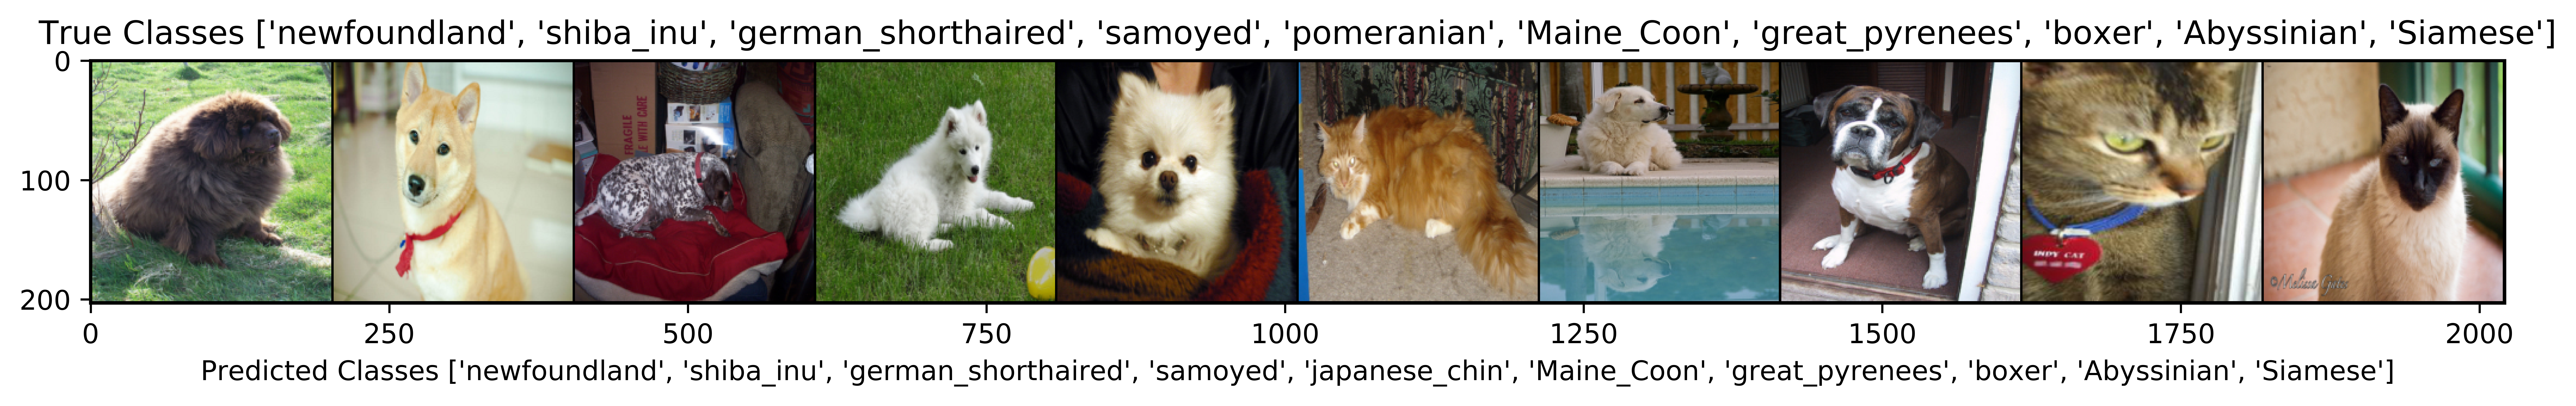

In [20]:
# Plotting with image
ten_by_ten = torchvision.utils.make_grid(img_test_batch[:10,:,:,:].detach().cpu(), nrow = 10)
plt.figure(figsize = (16,16),dpi = 1000)
plt.imshow(ten_by_ten.permute(1,2,0))
plt.title(f"True Classes {true_labels}")
plt.xlabel(f"Predicted Classes {predictions_labels}")
plt.show()

## Checking which images are more prone to be misrecognized

In [21]:
# Getting true labels and predictions
def cm_matrix(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad(): 
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            scores = model(imgs)
            predictions = torch.tensor([torch.argmax(i).item() for i in scores]).to(device) 
            num_correct+= (predictions == labels).sum()  
            num_samples+= predictions.size(0) 
        ## To check accuracy if ever needed
        #print(num_correct/ num_samples * 100)  
    return (predictions, labels)

In [22]:
pred_cm, true_labels_cm = cm_matrix(test_dataloader, model_inference)
cf_matrix = confusion_matrix(true_labels_cm.detach().cpu().numpy(), pred_cm.detach().cpu().numpy())

In [23]:
df_cm = pd.DataFrame(cf_matrix, index = dict_class_labels,
                     columns = dict_class_labels)

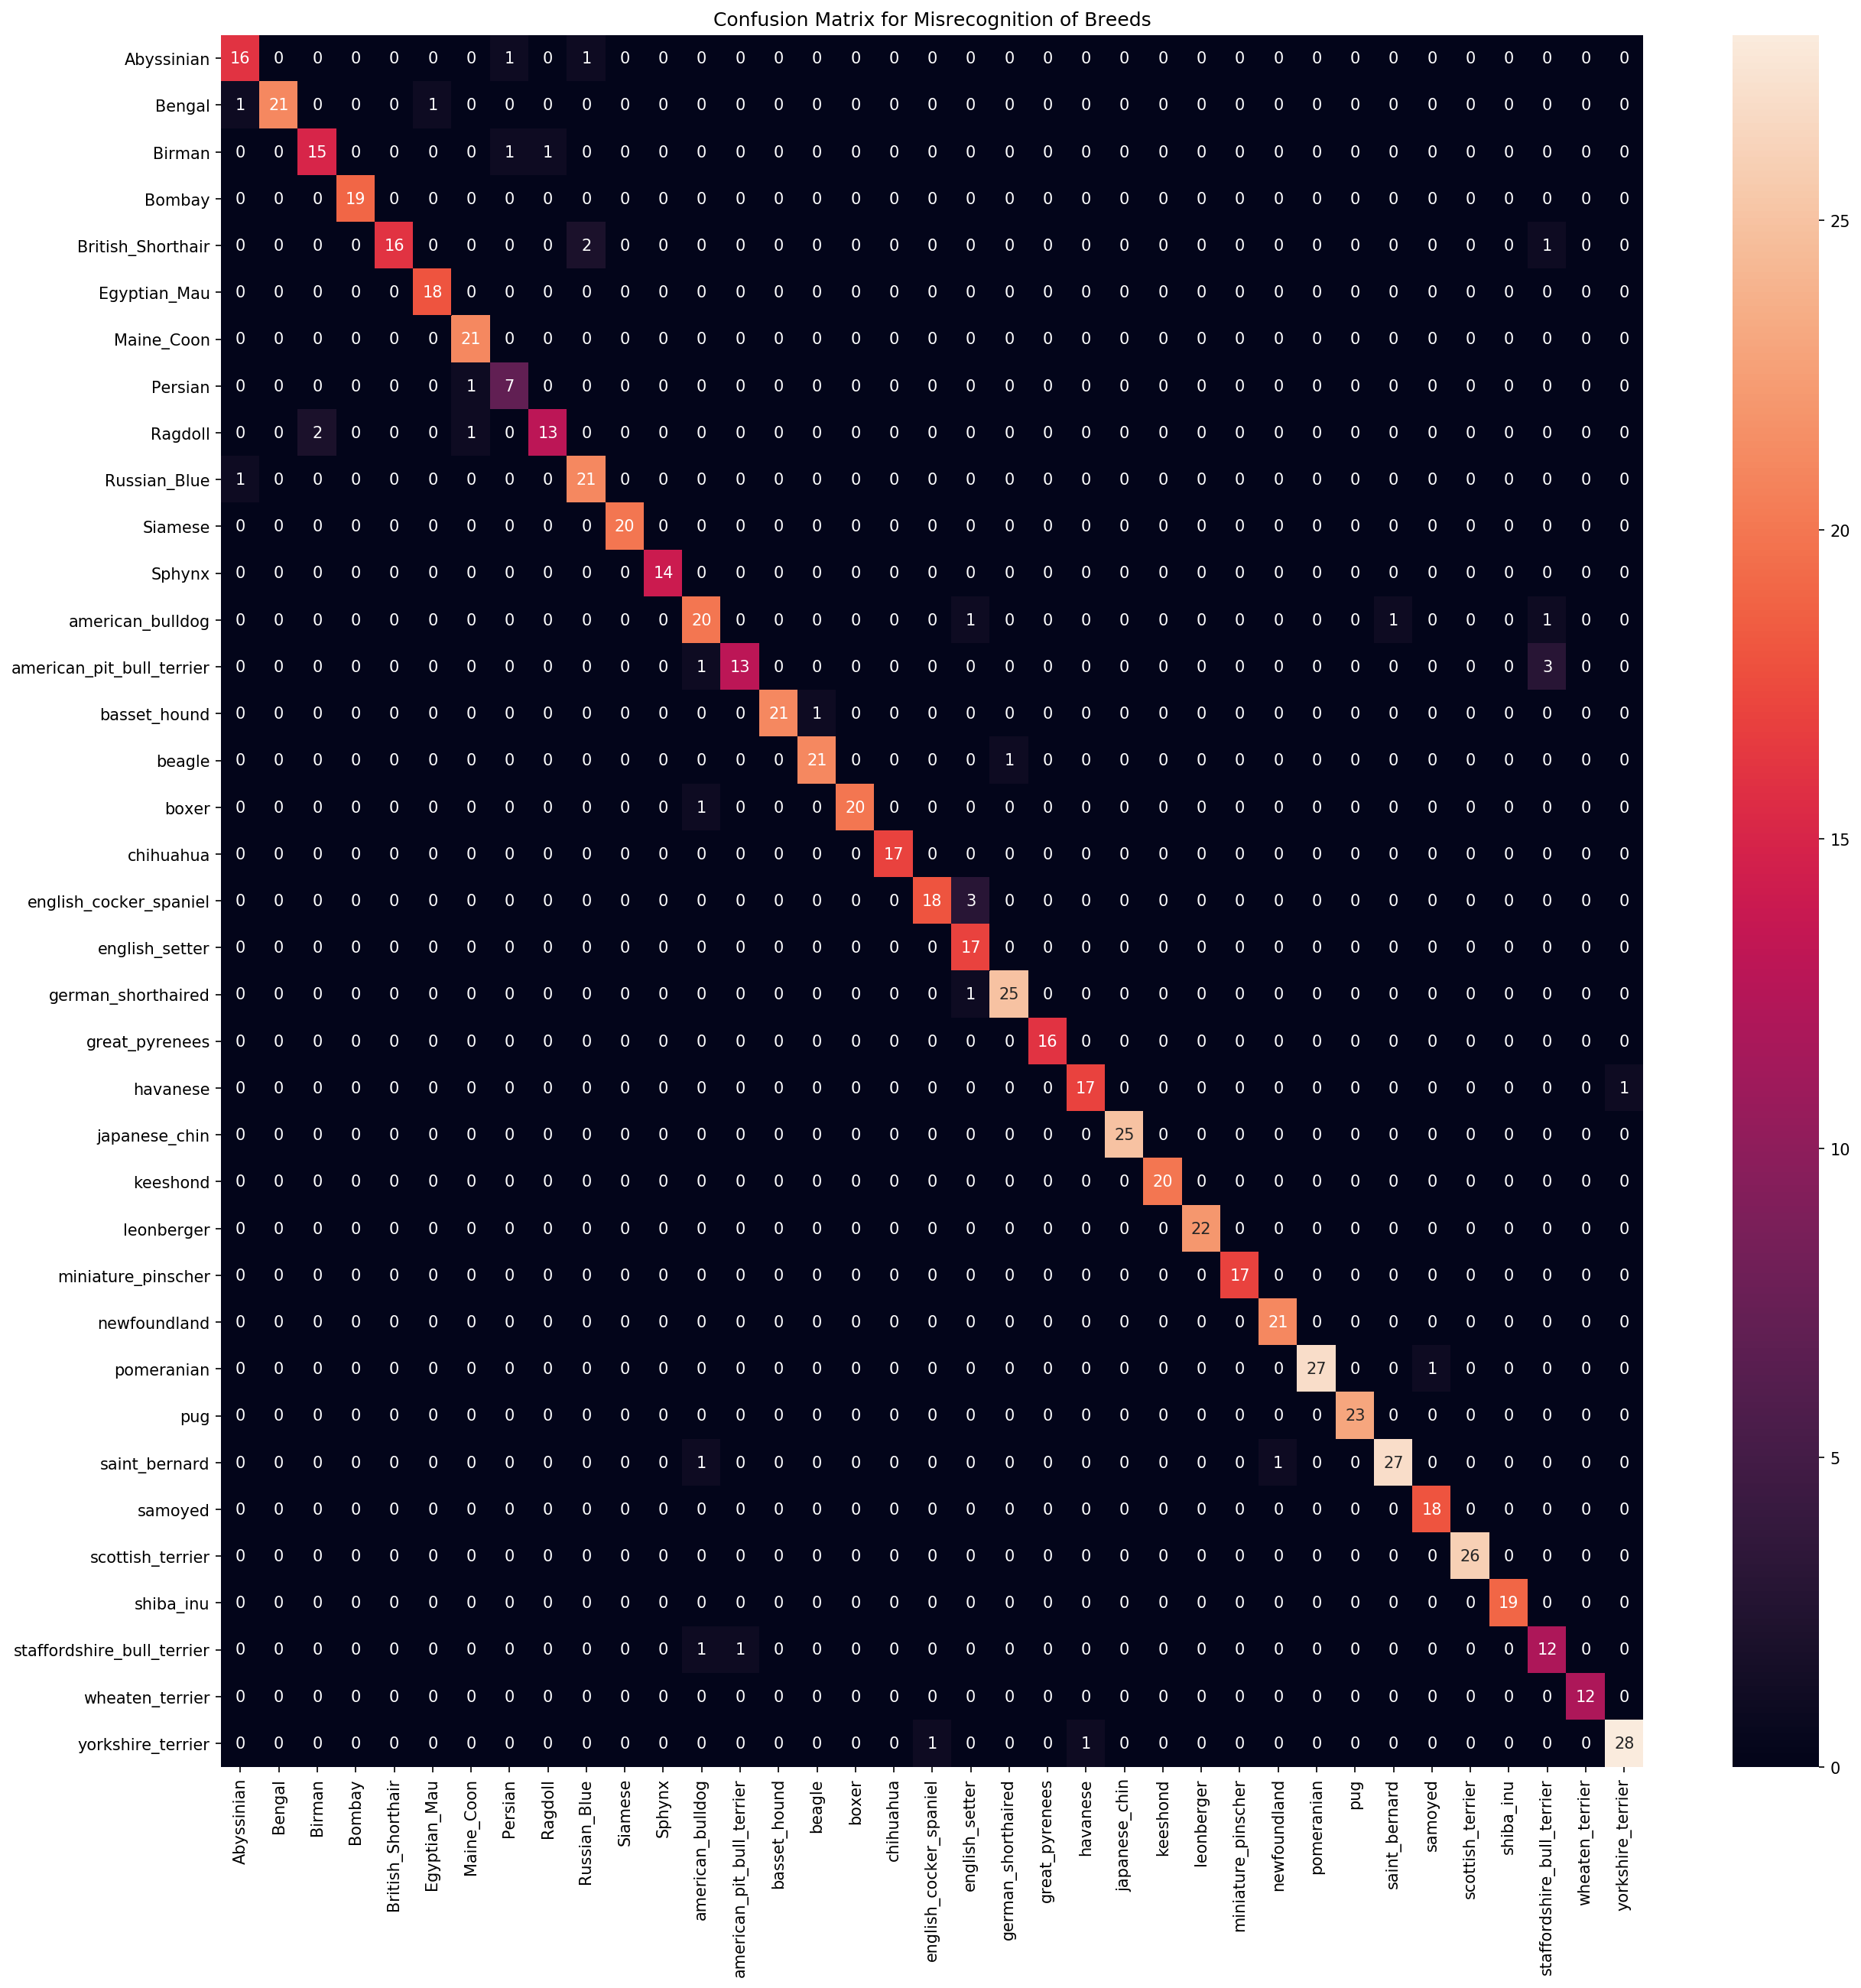

In [24]:
# Confusion matrix for misrecognition of breeds
plt.figure(figsize = (20,20),dpi = 150)
sns.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix for Misrecognition of Breeds")
plt.savefig('Confusion matrix for misrecognition.png')
plt.savefig('Confusion matrix for misrecognition.pdf')
plt.show()

## Testing Model Inference on Google Images

__Test 1__<br>
_Overall Steps:_ <br>
1) Get the images and resize.<br>
2) Make the predict.<br>
3) Run and check.<br>

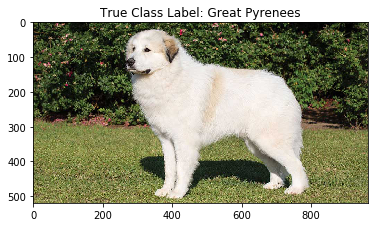

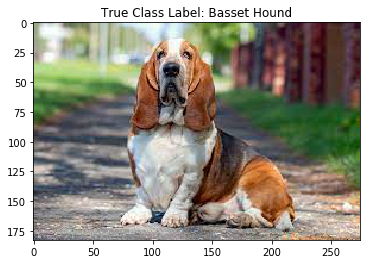

torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
[21, 14]
['great_pyrenees', 'basset_hound']


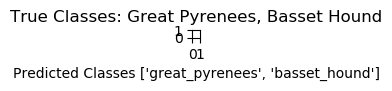

In [25]:
# Load image downloaded from Google
google_image = PIL.Image.open("great-pyrenees.jpg")
google_image_2 = PIL.Image.open("bass.jpg")

np_arr = np.array(google_image)

np_arr_2 = np.array(google_image_2)

np_arr.shape

np_arr_2.shape

plt.imshow(np_arr)
plt.title(f"True Class Label: Great Pyrenees")
plt.show()

plt.imshow(np_arr_2)
plt.title(f"True Class Label: Basset Hound")
plt.show()

google_image_tensor = torch.from_numpy(np_arr).permute(2,0,1)

google_image_tensor.size()

google_image_tensor_2 = torch.from_numpy(np_arr_2).permute(2,0,1)

google_image_tensor_2.size()

# Resize
transformations_list = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize(size = (200,200)),
     transforms.ToTensor()])
google_image_tensor_resized = transformations_list(google_image_tensor)
google_image_tensor_resized_2 = transformations_list(google_image_tensor_2)

print(google_image_tensor_resized.size())
print(google_image_tensor_resized_2.size())

# Gettinmg true label class names
concatented_imgs_batch = torch.cat((google_image_tensor_resized.unsqueeze(0),google_image_tensor_resized_2.unsqueeze(0)),dim = 0)
true_labels = [dict_class_labels.index('great_pyrenees'),dict_class_labels.index('basset_hound')]
concatented_imgs_batch = concatented_imgs_batch.type(torch.FloatTensor)
concatented_imgs_batch = concatented_imgs_batch.to(device)
# Getting Predicted Class Label Names
scores = model_inference(concatented_imgs_batch)
predictions_tensor = torch.tensor([torch.argmax(i).item() for i in scores]).to(device)
predictions_labels = [dict_class_labels[i] for i in predictions_tensor.detach().cpu().numpy()]
print(true_labels)
print(predictions_labels)

concatented_imgs_batch = concatented_imgs_batch.type(torch.ByteTensor)
two_by_two = torchvision.utils.make_grid(concatented_imgs_batch.detach().cpu(), nrow = 2)
plt.figure(figsize = (0.1,0.1),dpi = 100)
# plt.imshow(two_by_two.permute(1,2,0))
plt.title(f"True Classes: Great Pyrenees, Basset Hound")
plt.xlabel(f"Predicted Classes {predictions_labels}")
plt.show()

As seen above model is able to correctly classify images from Google